In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# TA-Lib for indicators
import talib

# PyNance and PyFolio will be used later, we just import them now
import talib                      # technical indicators
import pynance as py              # from GitHub version
import quantstats as qs   

# Make plots a bit nicer
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)


## Load or download a data (AAPL)

In [2]:
# ============================================
# Download META daily data for a year
# ============================================

ticker = "MSFT"
start_date = "2009-01-01"
end_date   = "2023-12-29"

df = yf.download(ticker, start=start_date, end=end_date, progress=False) 
df.head()


C:\Users\Birhanu Matebe\AppData\Local\Temp\ipykernel_9656\2390049828.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2009-01-02,14.845187,14.896302,14.144185,14.261019,50084000
2009-01-05,14.983939,15.093471,14.648041,14.750272,61475200
2009-01-06,15.159190,15.334441,15.049659,15.151888,58083400
2009-01-07,14.246425,14.815990,14.224518,14.742969,72709900
2009-01-08,14.691850,14.742964,14.275628,14.334045,70255400


# 1. Data profiling

In [3]:
# ============================================
# Clean the columns (handle MultiIndex case)
# ============================================

# If columns are MultiIndex (like: ('Close', 'MSFT')), flatten them
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)  # keep only first level: Open, High, etc.

print("Cleaned columns:", df.columns.tolist())

# Optional: add a Ticker column (useful if using multiple tickers later)
df["Ticker"] = ticker

# Ensure index is datetime and sorted
df.index = pd.to_datetime(df.index)
df = df.sort_index()




Cleaned columns: ['Close', 'High', 'Low', 'Open', 'Volume']


# - Summary Statistics 

In [4]:
# log the shape of dataset and the first five rows of dataset
print(f'the shape of META dataset ${df.shape}')
df.head()

the shape of META dataset $(3773, 6)


Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2009-01-02,14.845187,14.896302,14.144185,14.261019,50084000,MSFT
2009-01-05,14.983939,15.093471,14.648041,14.750272,61475200,MSFT
2009-01-06,15.159190,15.334441,15.049659,15.151888,58083400,MSFT
2009-01-07,14.246425,14.815990,14.224518,14.742969,72709900,MSFT
2009-01-08,14.691850,14.742964,14.275628,14.334045,70255400,MSFT


In [5]:
# log the last examples of this dataset
df.tail()

Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2023-12-21,368.052429,368.909643,364.603847,367.086815,17708000,MSFT
2023-12-22,369.077118,369.668309,367.234594,368.190346,17107500,MSFT
2023-12-26,369.155945,371.402449,368.012983,369.490946,12673100,MSFT
2023-12-27,368.574615,369.550062,367.333116,368.200193,14905400,MSFT
2023-12-28,369.766815,370.929473,368.663274,369.855489,14327000,MSFT


In [6]:
# log the last examples of this dataset
df.sample(5)

Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2012-03-20,25.218513,25.344647,25.021432,25.305228,41566800,MSFT
2022-12-06,239.396271,245.978892,238.087564,244.963184,22463700,MSFT
2021-02-24,225.578400,226.203531,220.240686,221.212048,26339700,MSFT
2016-09-13,50.515247,50.622482,50.086319,50.488440,30130200,MSFT
2023-07-19,348.417267,355.658793,345.826819,354.962124,39732900,MSFT


In [7]:
# check more information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3773 entries, 2009-01-02 to 2023-12-28
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3773 non-null   float64
 1   High    3773 non-null   float64
 2   Low     3773 non-null   float64
 3   Open    3773 non-null   float64
 4   Volume  3773 non-null   int64  
 5   Ticker  3773 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 206.3+ KB


In [8]:
# check if a null value exists
print("Check for missing values:")
df.isna().sum()

Check for missing values:


Price
Close     0
High      0
Low       0
Open      0
Volume    0
Ticker    0
dtype: int64

In [9]:
# 1. Calculate the percentage of missing values for every column
null_percentages = df.isnull().sum() / len(df) * 100

# 2. Filter the resulting Series for percentages greater than 5
columns_with_high_nulls = null_percentages[null_percentages > 5]

# 3. Print the results
print("Columns with >5% Null Values:")
print(columns_with_high_nulls)

Columns with >5% Null Values:
Series([], dtype: float64)


In [10]:
# Check if null rows exist
# 1. Define the critical columns
key_cols = ['Close', 'Open', 'High', 'Volume', 'Ticker']

# 2. Create a boolean mask:
missing_rows_mask = df[key_cols].isnull().any(axis=1)

# 3. Use the mask to display the subset of rows with missing data
missing_value_rows = df[missing_rows_mask]

# 4. Display the resulting DataFrame
print(f"Total rows with missing values in the key columns: {len(missing_value_rows)}")
print("Rows with Missing Data (only showing the key columns for focus):")
print(missing_value_rows[key_cols])

Total rows with missing values in the key columns: 0
Rows with Missing Data (only showing the key columns for focus):
Empty DataFrame
Columns: [Close, Open, High, Volume, Ticker]
Index: []


In [11]:
# log statistical data values
print("The description of the numeric columns:")
print(df.describe())

The description of the numeric columns:


Price        Close         High          Low         Open        Volume
count  3773.000000  3773.000000  3773.000000  3773.000000  3.773000e+03
mean    102.196189   103.176398   101.114345   102.158407  3.896290e+07
std     100.260387   101.256904    99.163542   100.227159  2.245682e+07
min      11.138553    11.484106    10.932693    11.175314  7.425600e+06
25%      23.677969    23.868408    23.448451    23.675077  2.399220e+07
50%      48.876568    49.086415    48.504363    48.771496  3.279140e+07
75%     165.375381   166.613094   162.528698   165.470607  4.865820e+07
max     377.077850   378.654341   372.604538   378.122296  3.193179e+08


In [12]:
#Overview of categorical columns
print("The description of the categorical columns:")
print(df.describe(include=['object']))

The description of the categorical columns:
Price  Ticker
count    3773
unique      1
top      MSFT
freq     3773


In [13]:
# log and check the frequency, and uniqueness of all dataset column
print("The description of all columns:")
print(df.describe(include='all'))


The description of all columns:
Price         Close         High          Low         Open        Volume  \
count   3773.000000  3773.000000  3773.000000  3773.000000  3.773000e+03   
unique          NaN          NaN          NaN          NaN           NaN   
top             NaN          NaN          NaN          NaN           NaN   
freq            NaN          NaN          NaN          NaN           NaN   
mean     102.196189   103.176398   101.114345   102.158407  3.896290e+07   
std      100.260387   101.256904    99.163542   100.227159  2.245682e+07   
min       11.138553    11.484106    10.932693    11.175314  7.425600e+06   
25%       23.677969    23.868408    23.448451    23.675077  2.399220e+07   
50%       48.876568    49.086415    48.504363    48.771496  3.279140e+07   
75%      165.375381   166.613094   162.528698   165.470607  4.865820e+07   
max      377.077850   378.654341   372.604538   378.122296  3.193179e+08   

Price  Ticker  
count    3773  
unique      1  
top    

In [14]:
#check if duplication of rows exist
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

Duplicate rows: 0


In [15]:
# Cardinality (uniqueness) for categoricals
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cardinality = {c: df[c].nunique() for c in cat_cols}
print("Cardinality (categoricals):", cardinality)

Cardinality (categoricals): {'Ticker': 1}


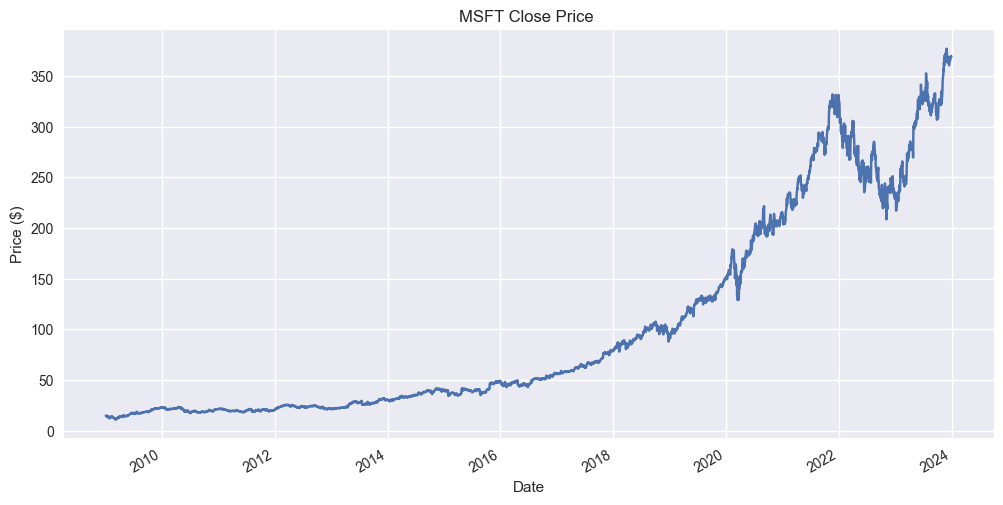

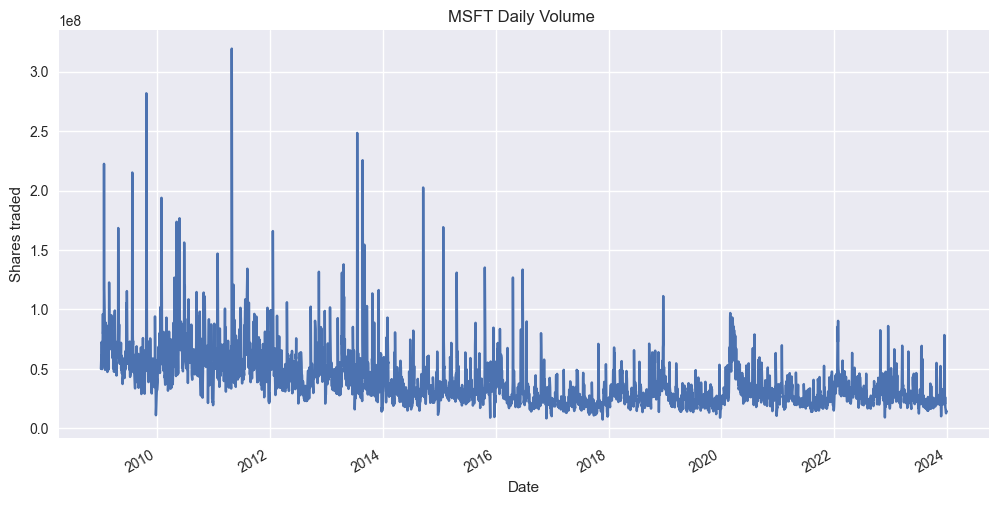

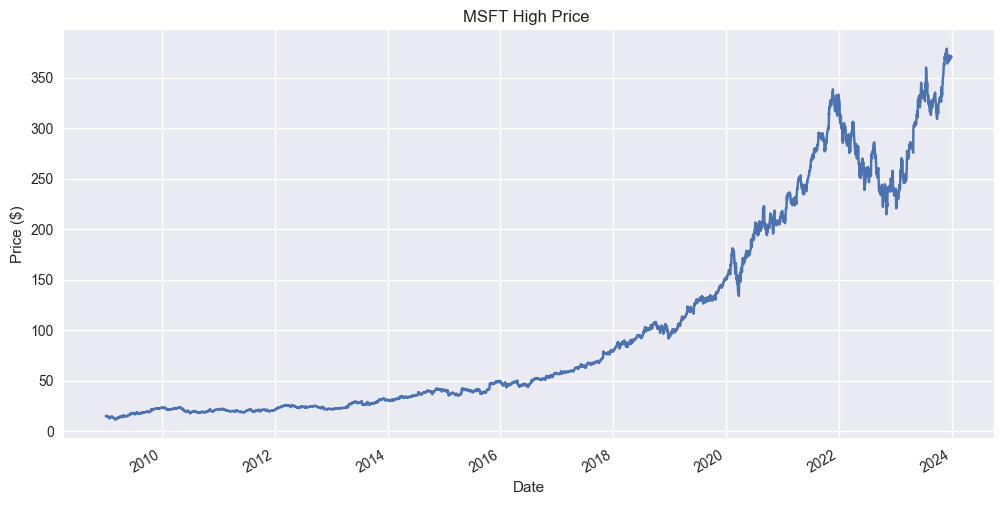

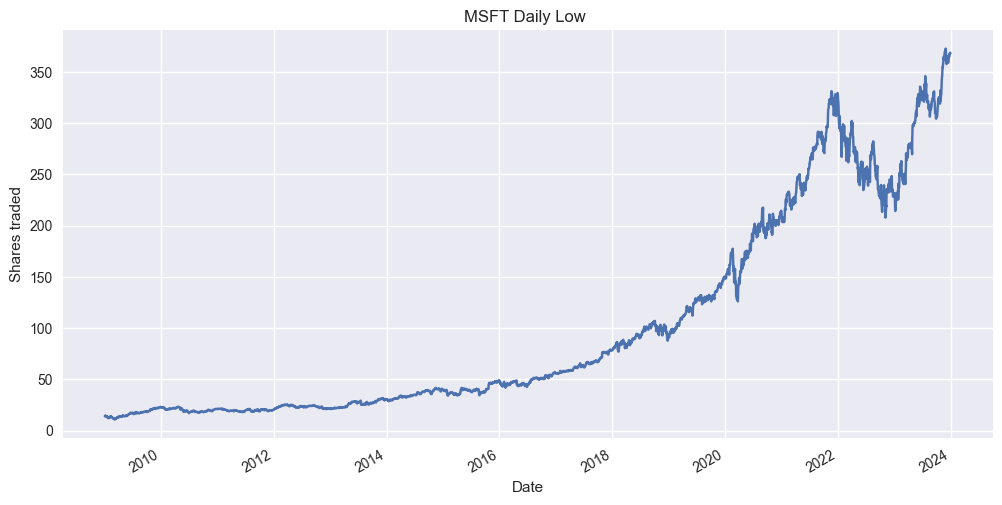

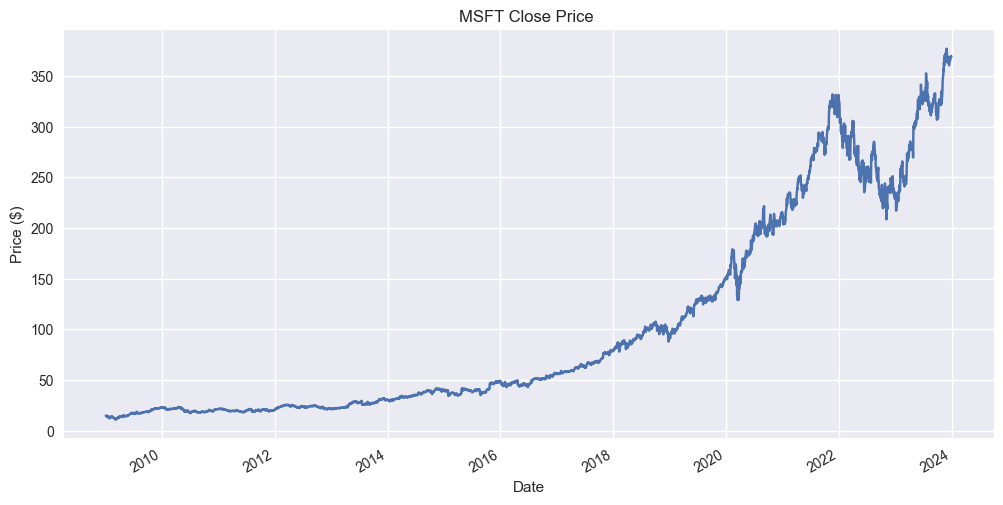

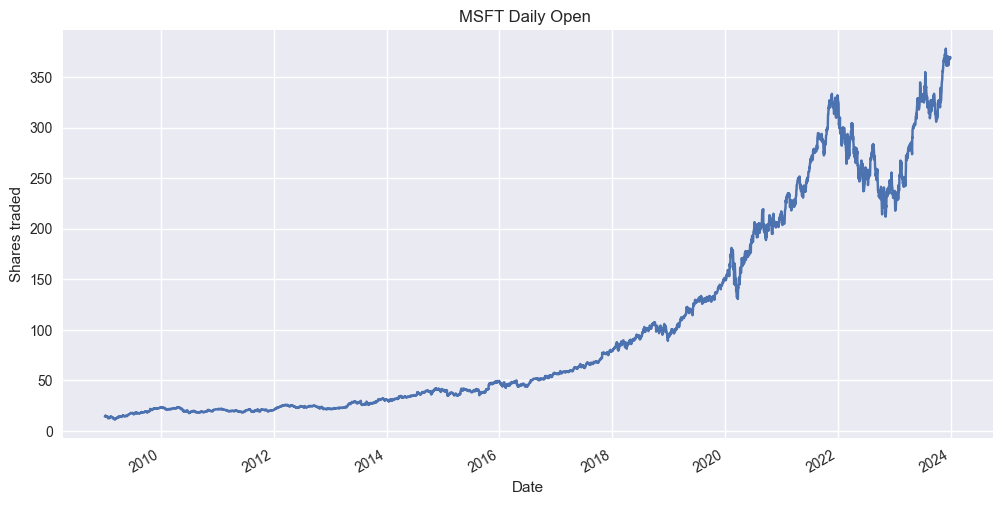

In [16]:
# ============================================
# Quick look at price and volume
# ============================================

# Close price chart
df["Close"].plot(title="MSFT Close Price ")
plt.ylabel("Price ($)")
plt.show()

# Volume chart
df["Volume"].plot(title="MSFT Daily Volume ")
plt.ylabel("Shares traded")
plt.show()
df["High"].plot(title="MSFT High Price ")
plt.ylabel("Price ($)")
plt.show()

# Volume chart
df["Low"].plot(title="MSFT Daily Low ")
plt.ylabel("Shares traded")
plt.show()
df["Close"].plot(title="MSFT Close Price ")
plt.ylabel("Price ($)")
plt.show()

# Volume chart
df["Open"].plot(title="MSFT Daily Open ")
plt.ylabel("Shares traded")
plt.show()


## Stock price over time

## Interpretation of Microsoft (MSFT) Close Price History (2009–2024)
- This chart, displaying the daily closing price of Microsoft stock over approximately the past 15 years, illustrates a period of extraordinary, stable, and high-conviction growth.

1. The Core Trend: Unrelenting, High-Conviction Growth
- The primary characteristic is the powerful, nearly uninterrupted upward trend that began decisively around 2014. The price rose dramatically from under $20 to its peak near $420 by early 2024. This massive appreciation reflects the success of the company's strategic shift under new leadership, focusing heavily on cloud computing (Azure), which provides reliable, high-margin revenue.

2. Key Phases of Price Movement
- 2009 – 2013: The Stable Base: Following the 2008 financial crisis, the stock price was relatively range-bound. This represents the stable but slow-growth era preceding the major strategic shift.

- 2014 – 2021: Cloud-Driven Surge: This period is defined by an aggressive, consistent, and low-volatility climb. The success of its enterprise software, cloud services, and subscription model earned high investor confidence, driving the price steadily higher.

- Late 2021 – Late 2022: A Moderate Correction: While the broader market experienced a deep downturn, Microsoft's correction was comparatively milder. The stock pulled back from its high but stabilized quickly. This resilience is attributed to the durable, high-margin revenue stream from its Intelligent Cloud segment, which acted as a stabilizing force during the macroeconomic uncertainty.

- 2023 – Early 2024: Recovery to New Highs: The price rapidly recovered back to new all-time highs. This momentum was fueled by continued strong performance in Azure and intense investor enthusiasm for the company's leadership and investment in AI (via its partnership with OpenAI).

3. Summary of Volatility
- Microsoft's chart is notable for its superior stability during periods of market stress. While the stock delivered immense long-term returns comparable to its high-growth peers, it did so with lower volatility, experiencing a moderate pullback rather than a catastrophic bear market crash in 2022. This speaks to the perceived quality and stability of its core enterprise and cloud businesses.

In [17]:
# ============================================
# Compute technical indicators with TA-Lib
# ============================================

# Use 'Adj Close' if available, otherwise 'Close'
if "Adj Close" in df.columns:
    price = df["Adj Close"]
else:
    price = df["Close"]

# --- Moving Averages ---
df["SMA_20"] = talib.SMA(price, timeperiod=20)
df["SMA_50"] = talib.SMA(price, timeperiod=50)
df["EMA_20"] = talib.EMA(price, timeperiod=20)

# --- RSI ---
df["RSI_14"] = talib.RSI(price, timeperiod=14)

# --- MACD ---
df["MACD"], df["MACD_signal"], df["MACD_hist"] = talib.MACD(
    price, fastperiod=12, slowperiod=26, signalperiod=9
)


df.tail()


Price,Close,High,Low,Open,Volume,Ticker,SMA_20,SMA_50,EMA_20,RSI_14,MACD,MACD_signal,MACD_hist
Date,,,,,,,,,,,,,
2023-12-21,368.052429,368.909643,364.603847,367.086815,17708000,MSFT,368.181953,353.546263,365.560397,55.314549,2.816369,4.091092,-1.274723
2023-12-22,369.077118,369.668309,367.234594,368.190346,17107500,MSFT,368.041550,354.415125,365.895323,56.363335,2.800177,3.832909,-1.032732
2023-12-26,369.155945,371.402449,368.012983,369.490946,12673100,MSFT,367.846954,355.353018,366.205858,56.448017,2.761868,3.618701,-0.856833
2023-12-27,368.574615,369.550062,367.333116,368.200193,14905400,MSFT,367.421793,356.182722,366.431454,55.591211,2.654006,3.425762,-0.771756
2023-12-28,369.766815,370.929473,368.663274,369.855489,14327000,MSFT,367.245912,357.047677,366.749108,57.031648,2.634358,3.267481,-0.633123


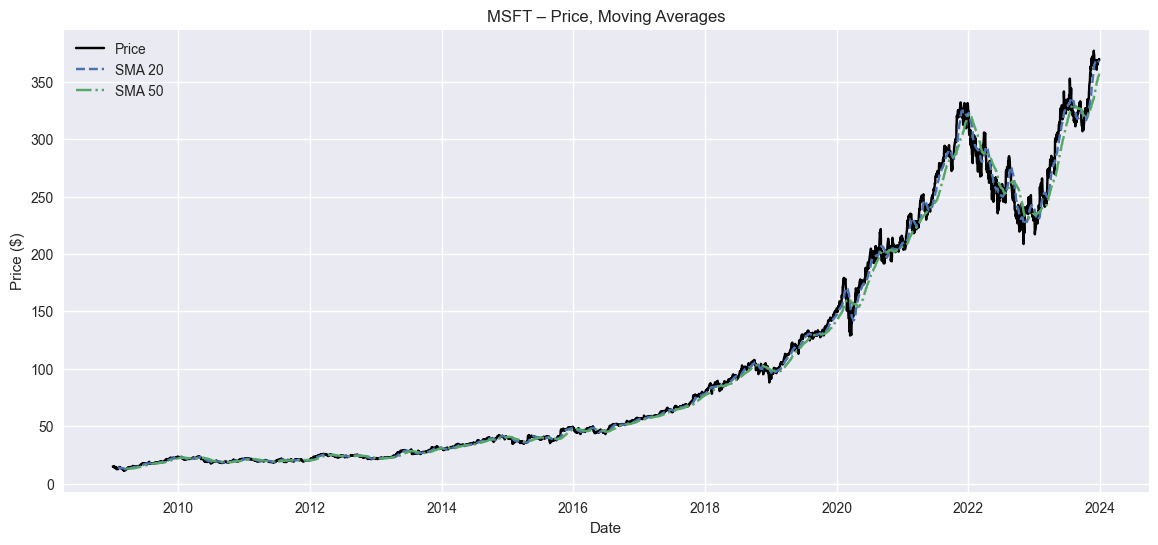

In [18]:
# ============================================
# Price + SMA + Bollinger Bands
# ============================================

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df.index, price, label="Price", color="black")
ax.plot(df.index, df["SMA_20"], label="SMA 20", linestyle="--")
ax.plot(df.index, df["SMA_50"], label="SMA 50", linestyle="-.")


ax.set_title("MSFT – Price, Moving Averages")
ax.set_xlabel("Date")
ax.set_ylabel("Price ($)")
ax.legend()
plt.show()


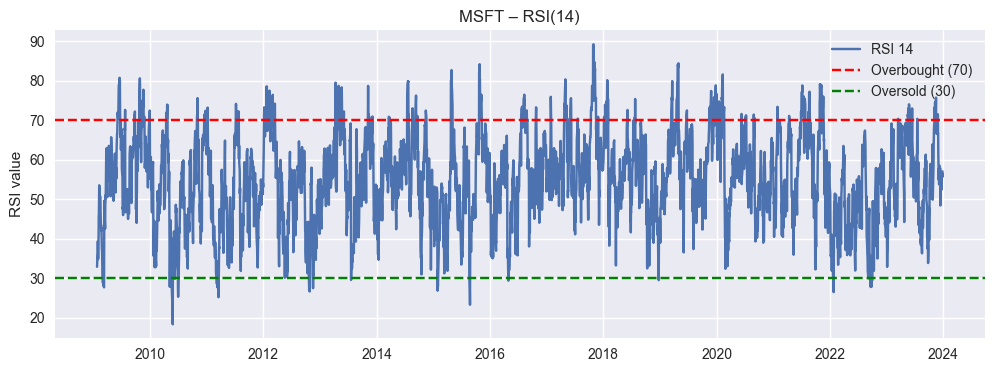

In [19]:
# ============================================
# RSI – Overbought / Oversold
# ============================================

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df.index, df["RSI_14"], label="RSI 14")
ax.axhline(70, color="red", linestyle="--", label="Overbought (70)")
ax.axhline(30, color="green", linestyle="--", label="Oversold (30)")

ax.set_title("MSFT – RSI(14)")
ax.set_ylabel("RSI value")
ax.legend()
plt.show()


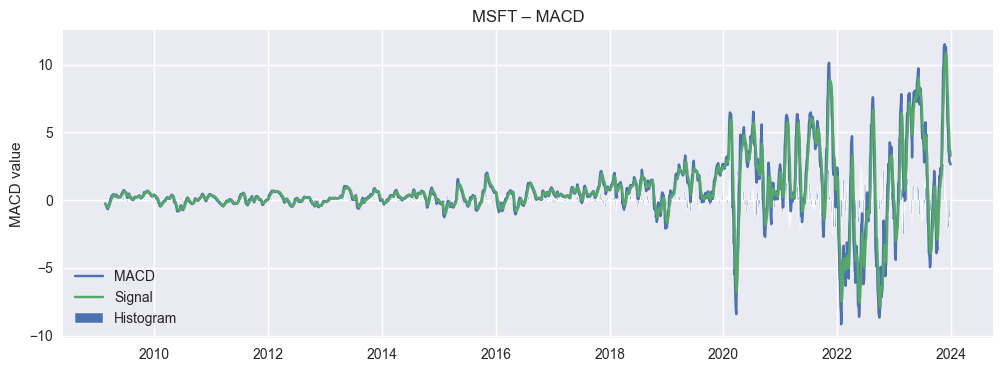

In [20]:
# ============================================
# MACD – Trend & momentum
# ============================================

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df.index, df["MACD"], label="MACD")
ax.plot(df.index, df["MACD_signal"], label="Signal")
ax.bar(df.index, df["MACD_hist"], label="Histogram")

ax.set_title("MSFT – MACD")
ax.set_ylabel("MACD value")
ax.legend()
plt.show()



## Interpretation of Microsoft (MSFT) Price and Moving Averages
1. The Dominant Bull Trend (2014–2021)
- Bullish Alignment: For this entire period, the Close Price (black line) remained clearly above both the SMA 20 (dashed blue) and SMA 50 (dotted green). Crucially, the SMA 20 was consistently above the SMA 50. This alignment is the clearest technical signal of a strong, established bull market.

- Dynamic Support: The moving averages acted as excellent dynamic support. During any moderate price pullback, the stock price reliably bounced off the SMA 20 or SMA 50 and resumed its climb, confirming persistent underlying demand.

2. The 2022 Resilience and Correction
- Mild Breakdown: The 2022 market downturn caused the price to break below both moving averages. However, the breakdown was mild and brief compared to other tech stocks.

- Avoided Prolonged Death Cross: The SMA 20 crossed below the SMA 50 ("Death Cross"), signaling a technical bear market, but this bearish crossover period was short. This limited duration shows that the stock's trend did not suffer a deep, long-lasting collapse.

- Swift Reversal: The price quickly reversed higher, and the SMA 20 soon crossed back above the SMA 50 ("Golden Cross"), confirming the rapid re-establishment of the bullish trend.

3. The 2023–2024 Re-Establishment
- By early 2024, the price is trading well above both moving averages, which are pointing sharply upward. This confirms the trend is fully restored and technically remains in a strong bull market.

## Interpretation of Microsoft (MSFT) Relative Strength Index (RSI 14)
- The RSI (14) measures the speed and change of MSFT's closing price. The key observation here is the consistent avoidance of the deep Oversold territory during the last major market correction.

1. The Long-Term Bullish Range
- Consistent Overbought (RSI > 70): The RSI line frequently enters the 70 (Overbought) threshold during its long uptrend (2014–2021). This is typical for a strong, aggressively-bought growth stock and signals sustained, high-conviction buying momentum.

- Neutral Zone Support (40–70): When the stock pulls back, the RSI consistently finds support well above the 30 line, often in the 40–50 range. This is the hallmark of a strong trend, where pullbacks are quickly bought up, preventing the stock from becoming technically oversold.

2. The Critical 2022 Correction Test
- Shallow Dip Towards Oversold: Unlike Amazon (AMZN) and Meta (META), whose RSI charts plunged deeply and for a sustained period into the Oversold zone (below 30), Microsoft's RSI barely touched the lower edge of the neutral territory during the 2022 correction.

- Significance: The RSI's resilience confirms the relative mildness and shortness of the MSFT price correction. It signals that the core selling pressure was not driven by panic or a catastrophic business failure but was a moderate, macroeconomic-driven technical pullback. The stock maintained much stronger momentum than its peers during this period.

3. The 2023 Recovery
- The RSI rebounded quickly in 2023, soaring back toward the Overbought region (RSI > 70). This confirms the high-momentum, aggressive buying that propelled the stock to new all-time highs, driven by its leadership in cloud and AI.

## Interpretation of Microsoft (MSFT) MACD
1. Long-Term Positive Momentum (Above the Zero Line)
- Sustained Bullish Bias: For almost the entire 2009–2021 period, the MACD Line and Signal Line were consistently positioned above the Zero Line. This is the technical confirmation of a strong, institutional-grade uptrend, meaning positive momentum was dominant.

- Low Volatility: The oscillations (swings) above the zero line are generally smoother and less extreme than those seen in the charts for AMZN or META, reflecting the overall lower volatility of the MSFT stock.

2. The 2022 Resilience and Correction
- Shallow Dip Below Zero: The most critical observation is that when the MACD crossed below the Zero Line in 2022, signaling a temporary technical bear market, the depth and duration of the dip were significantly less severe than those seen in the other high-volatility tech stocks.

- Significance: This shallow plunge confirms the resilience of Microsoft's momentum. The momentum did not experience a catastrophic collapse, underscoring the stability of its high-margin revenue streams (like Azure).

3. The 2023–2024 Recovery
- Swift Return to Positive: The MACD line crossed back above the Zero Line quickly, stabilizing strongly in positive territory as the price recovered. This confirms the aggressive, high-conviction buying that returned to the stock.

- Current Status (Early 2024): The MACD is in a high positive range, indicating strong bullish momentum is currently dominant.